# KLUE BERT를 이용한 DKTC 감정 분류
<br>

## 1. 데이터 로드 및 확인
<br>

#### 필요 라이브러리 가져오기
<br>

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.7 MB/s eta 0:00:00


In [ ]:
!pip install soynlp

  Using cached soynlp-0.0.493-py3-none-any.whl (416 kB)


In [ ]:
!pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 40.4 MB/s eta 0:00:00


In [ ]:
!apt-get update
!apt-get install g++ openjdk-8-jdk python3-dev python3-pip curl
!python3 -m pip install --upgrade pip
!python3 -m pip install konlpy
!curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh | bash -x

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [493 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease [18.1 kB]
Get:8 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [990 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,251 kB]
Get:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Package

In [ ]:
import pandas as pd
import numpy as np
import re
import urllib.request
import os
from tqdm import tqdm
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from soynlp.normalizer import *
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS

<br>

#### 데이터 셋(DKTC) 가져오기
<br>

In [ ]:
#### 데이터 가져오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/Colab/05_Colab_AIFFEL_2023/10_Main_Quest_03/data/train.csv')

In [ ]:
print('훈련용 문단 개수 :',len(train_data))

훈련용 문단 개수 : 3950


In [ ]:
train_data.head()

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


<br>

#### 세부 데이터 확인
<br>

In [ ]:
# class별 데이터 내용 확인

In [ ]:
print(train_data['conversation'][0]) # 협박

지금 너 스스로를 죽여달라고 애원하는 것인가?
 아닙니다. 죄송합니다.
 죽을 거면 혼자 죽지 우리까지 사건에 휘말리게 해? 진짜 죽여버리고 싶게.
 정말 잘못했습니다.
 너가 선택해. 너가 죽을래 네 가족을 죽여줄까.
 죄송합니다. 정말 잘못했습니다.
 너에게는 선택권이 없어. 선택 못한다면 너와 네 가족까지 모조리 죽여버릴거야.
 선택 못하겠습니다. 한번만 도와주세요.
 그냥 다 죽여버려야겠군. 이의 없지?
 제발 도와주세요.


In [ ]:
print(train_data['conversation'][2]) # 기타 괴롭힘

너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.
그만해. 니들 놀리는거 재미없어.
지영아 너가 키 160이지? 그럼 재는 160도 안돼는거네?
너 군대도 안가고 좋겠다.
니들이 나 작은데 보태준거 있냐?
난쟁이들도 장가가고하던데. 너도 희망을 가져봐 
더이상 하지마라. 
그 키크는 수술도 있대잖아? 니네 엄마는 그거 안해주디?
나람 해줬어. 저 키로 어찌살아.
제발 그만 괴롭히라고!


In [ ]:
print(train_data['conversation'][3]) # 갈취

어이 거기
예??
너 말이야 너. 이리 오라고
무슨 일.
너 옷 좋아보인다?
얘 돈 좀 있나봐
아니에요.돈 없어요
뒤져서 나오면 넌 죽는다
오늘 피시방 콜?
콜. 마지막 기회다. 있는거 다 내놔
정말 없어요


In [ ]:
print(train_data['conversation'][3947]) # 직장 내 괴롭힘

나는 씨 같은 사람 보면 참 신기하더라. 어떻게 저렇게 살지.
왜 그래. 들리겠어.
들리라고 해. 아니 일 못해 눈치 없어. 본인도 슬슬 깨달아야 되지 않나?
하긴 그래서 저번에 부장님도.
그렇다니깐! 부장님이 진짜 착하신 분인데 오죽 답답했으면 말을 했겠어?
그러게.
회사생활 같이 한게 몇년인데 대답 하나 제대로 네 하고 싹싹하게 하는걸 못봤어.
나도 그건 못본거 같다.
지금도 그래. 야 야! 너 바로 앞에서 얘기하는데 귀가 먹어서 안들리는거니 안들리는척 하는거니? 뭐 말 좀 해봐?
야 너 왜 그래.
말씀이 너무 심하신거 아니에요?


<br><br>

## 2. 데이터 전처리
<br>

#### 중복 데이터와 결측값 제거
<br>

In [ ]:
# conversation 열에서 중복인 내용이 있다면 중복 제거

In [ ]:
len(train_data['conversation'])

3950

In [ ]:
train_data.drop_duplicates(subset=['conversation'], inplace=True)

In [ ]:
len(train_data['conversation'])

3846

<br>

In [ ]:
# Null 값이 존재하는 행 제거

In [ ]:
len(train_data)

3846

In [ ]:
train_data = train_data.dropna(how='any')

In [ ]:
print('훈련 데이터의 대화문 수:',len(train_data))

훈련 데이터의 대화문 수: 3846


<br>

In [ ]:
# NaN 값을 포함하는 행 제거

In [ ]:
train_data = train_data.dropna(subset=['class'])

In [ ]:
len(train_data)

3846

In [ ]:
# NaN 값 제거 확인
print(train_data['class'].unique())

['협박 대화' '기타 괴롭힘 대화' '갈취 대화' '직장 내 괴롭힘 대화']


In [ ]:
# train_data의 'class' 컬럼에 어떤 유니크한 값들이 있는지 확인
unique_labels = train_data['class'].unique()
unique_labels

array(['협박 대화', '기타 괴롭힘 대화', '갈취 대화', '직장 내 괴롭힘 대화'], dtype=object)

<br>

#### 불용어 제거
<br>

In [ ]:
from soynlp.normalizer import *

In [ ]:
# soynlp 이용하여 ㅋㅋㅋ, ㅠㅠ 등을 처리하고 반복 제거함(default 2)
# 알파벳과 한글 제외한 문법기호, 특수문자, 숫자 등 제거

def preprocess_sentence(sentence):
    emoticon_normalize(sentence)
    repeat_normalize(sentence)
    sentence = re.sub(r'([^a-zA-Zㄱ-ㅎ가-힣])', " ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = sentence.strip()
    return sentence

<br>

In [ ]:
train_data['conversation'][0]

'지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 거면 혼자 죽지 우리까지 사건에 휘말리게 해? 진짜 죽여버리고 싶게.\n 정말 잘못했습니다.\n 너가 선택해. 너가 죽을래 네 가족을 죽여줄까.\n 죄송합니다. 정말 잘못했습니다.\n 너에게는 선택권이 없어. 선택 못한다면 너와 네 가족까지 모조리 죽여버릴거야.\n 선택 못하겠습니다. 한번만 도와주세요.\n 그냥 다 죽여버려야겠군. 이의 없지?\n 제발 도와주세요.'

In [ ]:
train_list = []
for sentence in train_data['conversation']:
    train_list.append(preprocess_sentence(sentence))

In [ ]:
train_list[0]

'지금 너 스스로를 죽여달라고 애원하는 것인가 아닙니다 죄송합니다 죽을 거면 혼자 죽지 우리까지 사건에 휘말리게 해 진짜 죽여버리고 싶게 정말 잘못했습니다 너가 선택해 너가 죽을래 네 가족을 죽여줄까 죄송합니다 정말 잘못했습니다 너에게는 선택권이 없어 선택 못한다면 너와 네 가족까지 모조리 죽여버릴거야 선택 못하겠습니다 한번만 도와주세요 그냥 다 죽여버려야겠군 이의 없지 제발 도와주세요'

<br>

## 3. EDA
<br>

#### 데이터 길이 분포
<br>

max len:  839
mean len:  213.6638065522621


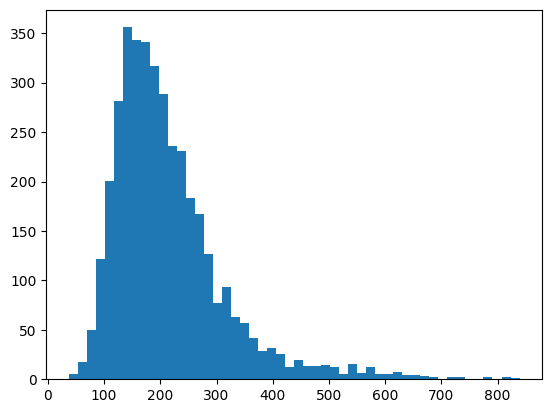

In [ ]:
print('max len: ', max(len(review) for review in train_list)) # 데이터셋 내 최대 문장 길이
print('mean len: ', sum(map(len, train_list))/len(train_list)) # 데이터셋 문장 길이 평균
plt.hist([len(review) for review in train_list], bins=50)
plt.show() # 문장 길이 분포 확인

<br>

<br><br>

## 4. BERT 의 입력
<br>

#### klue/bert‑base 토크나이저 로드
<br>

In [ ]:
tokenizer = BertTokenizer.from_pretrained('klue/bert-base')

<br>

#### 토크나이저 동작 확인
<br>

In [ ]:
print(tokenizer.tokenize("네 가지 종류의 협박에 대한 내용의 문장을 분류"))

['네', '가지', '종류', '##의', '협박', '##에', '대한', '내용', '##의', '문장', '##을', '분류']


In [ ]:
print(tokenizer.encode("네 가지 종류의 협박에 대한 내용의 문장을 분류"))

[2, 752, 3663, 5285, 2079, 8882, 2170, 3618, 3800, 2079, 6265, 2069, 5784, 3]


In [ ]:
tokenizer.decode(
   tokenizer.encode("네 가지 종류의 협박에 대한 내용의 문장을 분류")
)

'[CLS] 네 가지 종류의 협박에 대한 내용의 문장을 분류 [SEP]'

In [ ]:
max_seq_len = 400

encoded_result = tokenizer.encode("네 가지 종류의 협박에 대한 내용의 문장을 분류",
                                  max_length=max_seq_len, pad_to_max_length=True)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
print(encoded_result)

[2, 752, 3663, 5285, 2079, 8882, 2170, 3618, 3800, 2079, 6265, 2069, 5784, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
print('길이:', len(encoded_result))

길이: 400


In [ ]:
print([0]*max_seq_len)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
valid_num = len(tokenizer.encode("전율을 일으키는 영화. 다시 보고싶은 영화"))

In [ ]:
valid_num

14

In [ ]:
print(valid_num * [1] + (max_seq_len - valid_num) * [0])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

<br>

#### 토크나이징 및 인코딩 & 어텐션 마스크
<br>

In [ ]:
# 정수 인코딩을 위한 레이블-숫자 매핑 작업

In [ ]:
# 레이블 값을 숫자로 매핑
label_mapping = {
    '협박 대화': 0,
    '갈취 대화': 1,
    '직장 내 괴롭힘 대화': 2,
    '기타 괴롭힘 대화': 3
}

# train_data와 test_data의 레이블 값을 숫자로 변환
train_data['class'] = train_data['class'].map(label_mapping)
# test_data['class'] = test_data['class'].map(label_mapping)

<br>

In [ ]:
max_seq_len = 300

In [ ]:
def convert_examples_to_features(examples, labels, max_seq_len, tokenizer):

    input_ids, attention_masks, token_type_ids, data_labels = [], [], [], []

    for example, label in tqdm(zip(examples, labels), total=len(examples)):
        # input_id는 워드 임베딩을 위한 문장의 정수 인코딩
        input_id = tokenizer.encode(example, max_length=max_seq_len,
                                    pad_to_max_length=True)

        # attention_mask는 실제 단어가 위치하면 1, 패딩의 위치에는 0인 시퀀스
        padding_count = input_id.count(tokenizer.pad_token_id)
        attention_mask = [1] * (max_seq_len - padding_count) + [0] * padding_count

        # token_type_id은 세그먼트 인코딩
        token_type_id = [0] * max_seq_len

        assert len(input_id) == max_seq_len, "Error with input length {} vs {}".format(len(input_id), max_seq_len)
        assert len(attention_mask) == max_seq_len, "Error with attention mask length {} vs {}".format(len(attention_mask), max_seq_len)
        assert len(token_type_id) == max_seq_len, "Error with token type length {} vs {}".format(len(token_type_id), max_seq_len)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        data_labels.append(label)

    input_ids = np.array(input_ids, dtype=int)
    attention_masks = np.array(attention_masks, dtype=int)
    token_type_ids = np.array(token_type_ids, dtype=int)

    data_labels = np.asarray(data_labels, dtype=np.int32)

    return (input_ids, attention_masks, token_type_ids), data_labels

In [ ]:
# 이제 다시 convert_examples_to_features 함수를 실행
train_X, train_y = convert_examples_to_features(
    train_list, train_data['class'],
    max_seq_len=max_seq_len, tokenizer=tokenizer
)

  0%|          | 0/3846 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 3846/3846 [00:03<00:00, 1132.90it/s]


<br>

In [ ]:
# 훈련 데이터의 첫 번째 샘플에 대해 출력

In [ ]:
input_id = train_X[0][0]
attention_mask = train_X[1][0]
token_type_id = train_X[2][0]
label = train_y[0]

In [ ]:
print('단어에 대한 정수 인코딩:',input_id)

단어에 대한 정수 인코딩: [    2  3660   743  4201  2138 11287  2448  7245 20336  2205  2259   575
  2179  2116  6525  7822 11800  1565  2069   568  2460  4638  1565  2118
  3616  2299  2118  3863  2170 27063  2318  1897  4229 11287 10592  2088
  1335  2318  3944  4389  2371  2219  3606   743  2116  4025  2097   743
  2116  1565  2069  2315   752  3937  2069 11287  2776  2299  7822 11800
  3944  4389  2371  2219  3606   743  2170  2318  2259  4025  2207  2052
  1415  2051  4025 15110   743  2522   752  3937  2299  2118 14461 11287
 21992  2180  2275  4025  3818  2918  2219  3606  6791  2154  5232  2223
  5971  4181   809 11287 12432  2275  2918  2242 13519  1415  2118  8786
  5232  2223  5971     3     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0

In [ ]:
print('어텐션 마스크:',attention_mask)

어텐션 마스크: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]


In [ ]:
print('세그먼트 인코딩:',token_type_id)

세그먼트 인코딩: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]


In [ ]:
print('각 인코딩의 길이:', len(input_id))

각 인코딩의 길이: 300


In [ ]:
print('정수 인코딩 복원:',tokenizer.decode(input_id))

정수 인코딩 복원: [CLS] 지금 너 스스로를 죽여달라고 애원하는 것인가 아닙니다 죄송합니다 죽을 거면 혼자 죽지 우리까지 사건에 휘말리게 해 진짜 죽여버리고 싶게 정말 잘못했습니다 너가 선택해 너가 죽을래 네 가족을 죽여줄까 죄송합니다 정말 잘못했습니다 너에게는 선택권이 없어 선택 못한다면 너와 네 가족까지 모조리 죽여버릴거야 선택 못하겠습니다 한번만 도와주세요 그냥 다 죽여버려야겠군 이의 없지 제발 도와주세요 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

In [ ]:
print('레이블:',label)

레이블: 0


<br><br>

## 5. BERT 를 이용한 Many‑to‑One 모델 구현 및 학습
<br>

In [ ]:
# 모델 구현

In [ ]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

class TFBertForMultiClassClassification(tf.keras.Model):
    def __init__(self, model_name, num_classes, dropout_rate=0.1):
        super(TFBertForMultiClassClassification, self).__init__()
        self.bert = TFBertModel.from_pretrained(model_name, from_pt=True)
        self.dropout = Dropout(dropout_rate)
        self.classifier = tf.keras.layers.Dense(num_classes,
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(0.02),
                                                kernel_regularizer=l2(0.01),  # L2 Regularization
                                                activation='softmax',
                                                name='classifier')

    def call(self, inputs):
        input_ids, attention_mask, token_type_ids = inputs
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids)
        cls_token = outputs[1]
        dropped = self.dropout(cls_token)
        prediction = self.classifier(dropped)
        return prediction

In [ ]:
model = TFBertForMultiClassClassification("klue/bert-base", 4)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

<br>

In [ ]:
# 모델 설정

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()

In [ ]:
model.compile(optimizer=optimizer, loss=loss, metrics = ['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

<br>

In [ ]:
# 모델 학습

In [ ]:
history = model.fit(
    train_X, train_y,
    epochs=5, batch_size=16,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/5
193/193 [==============================] - 229s 1s/step - loss: 0.5592 - accuracy: 0.8209 - val_loss: 0.4474 - val_accuracy: 0.8740
Epoch 2/5
193/193 [==============================] - 207s 1s/step - loss: 0.2618 - accuracy: 0.9334 - val_loss: 0.4799 - val_accuracy: 0.8740


<br>

In [ ]:
# Loss와 Accuracy 시각화

In [ ]:
def plot_training_history(history):
    # Loss plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss Evolution')

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy Evolution')

    plt.tight_layout()
    plt.show()

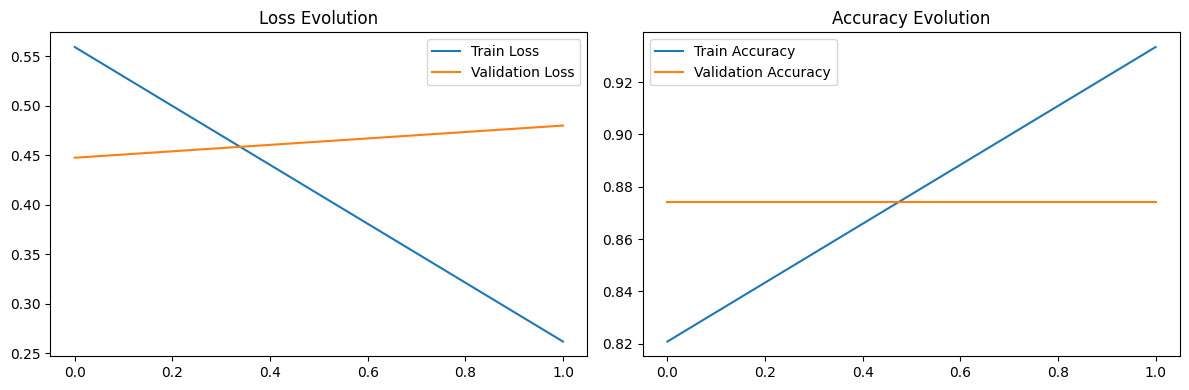

In [ ]:
plot_training_history(history)

In [ ]:
def plot_modified_training_history(history):
    # Loss plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.ylim([0, 2])  # 설정한 y-axis 범위
    plt.legend()
    plt.title('Loss Evolution')

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.ylim([0.5, 1])  # 설정한 y-axis 범위
    plt.legend()
    plt.title('Accuracy Evolution')

    plt.tight_layout()
    plt.show()

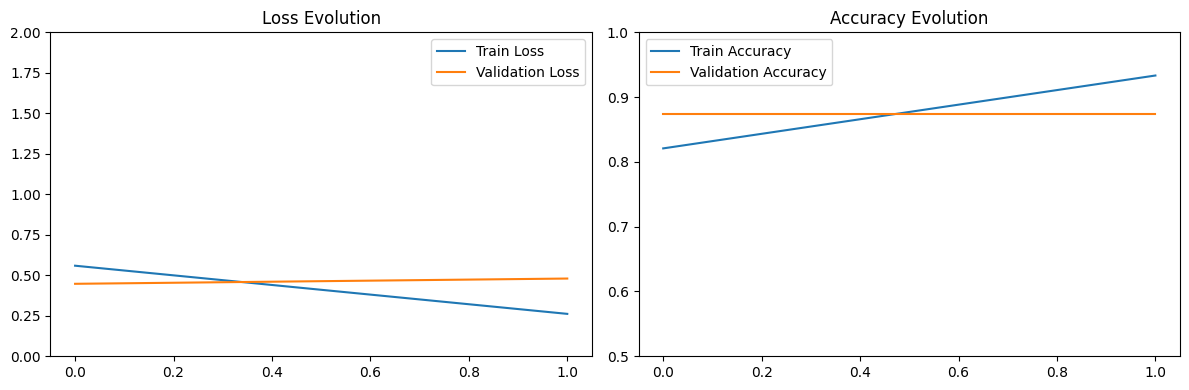

In [ ]:
plot_modified_training_history(history)

<br>

## 6. 평가 및 성능 지표
<br>

121/121 [==============================] - 84s 675ms/step
Real Accuracy: 0.9347
              precision    recall  f1-score   support

     Class 0       0.97      0.89      0.93       892
     Class 1       0.93      0.92      0.93       973
     Class 2       0.95      0.99      0.97       970
     Class 3       0.89      0.94      0.91      1011

    accuracy                           0.93      3846
   macro avg       0.94      0.93      0.93      3846
weighted avg       0.94      0.93      0.93      3846


Weighted F1 Score (based on real predictions): 0.9347


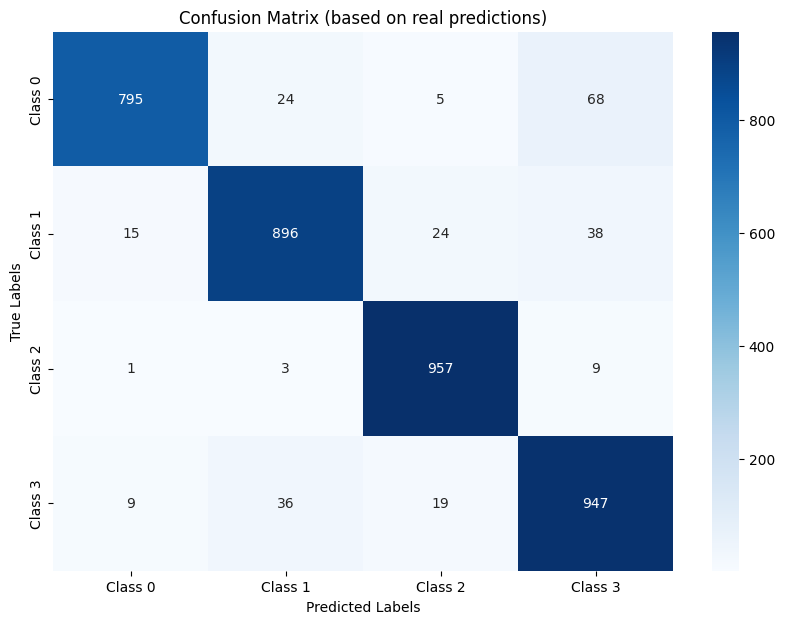

In [ ]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.metrics import accuracy_score

# 실제 예측값 생성
real_predictions = model.predict(train_X)

# 예측값을 레이블로 변환
real_predicted_labels = np.argmax(real_predictions, axis=1)

# 정확도 계산
real_accuracy = accuracy_score(train_y, real_predicted_labels)
print(f"Real Accuracy: {real_accuracy:.4f}")

# 분류 보고서 생성
real_report = classification_report(train_y, real_predicted_labels, target_names=[f"Class {i}" for i in range(4)])
print(real_report)

# F1 스코어 계산
real_f1 = f1_score(train_y, real_predicted_labels, average='weighted')
print(f"\nWeighted F1 Score (based on real predictions): {real_f1:.4f}")

# 혼동 행렬 생성 및 표시
real_conf_matrix = confusion_matrix(train_y, real_predicted_labels)
plt.figure(figsize=(10,7))
sns.heatmap(real_conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=[f"Class {i}" for i in range(4)], yticklabels=[f"Class {i}" for i in range(4)])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (based on real predictions)')
plt.show()

<br><br>

## 7. 예측 정확도 확인
<br>

In [ ]:
# 예측 함수 구현

In [ ]:
def multi_class_predict(new_sentence):
    input_id = tokenizer.encode(new_sentence,
                                max_length=max_seq_len,
                                pad_to_max_length=True)
    padding_count = input_id.count(tokenizer.pad_token_id)
    attention_mask = [1] * (max_seq_len - padding_count) + [0] * padding_count
    token_type_id = [0] * max_seq_len

    input_ids = np.array([input_id])
    attention_masks = np.array([attention_mask])
    token_type_ids = np.array([token_type_id])

    encoded_input = [input_ids, attention_masks, token_type_ids]
    score = model.predict(encoded_input)[0]

    class_names = ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화']
    max_score_index = np.argmax(score)
    predicted_class = class_names[max_score_index]
    probability = score[max_score_index] * 100  # 확률을 %로 변환

    print("해당 문장은 {:.2f}%의 확률로 '{}'로 분류됩니다.".format(probability, predicted_class))

<br>

In [ ]:
# 예측1

In [ ]:
multi_class_predict("죽고싶니?")

1/1 [==============================] - 0s 69ms/step
해당 문장은 57.97%의 확률로 '협박 대화'로 분류됩니다.


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


<br>

In [ ]:
# 예측2

In [ ]:
multi_class_predict("정 팀장 그것밖에 못해?")

1/1 [==============================] - 0s 69ms/step
해당 문장은 90.04%의 확률로 '직장 내 괴롭힘 대화'로 분류됩니다.


<br>

In [ ]:
# 예측3

In [ ]:
multi_class_predict("공과 사는 구분하자 좀")

1/1 [==============================] - 0s 69ms/step
해당 문장은 93.51%의 확률로 '기타 괴롭힘 대화'로 분류됩니다.


<br>

In [ ]:
# 예측4

In [ ]:
multi_class_predict("오늘 야근해")

1/1 [==============================] - 0s 69ms/step
해당 문장은 49.46%의 확률로 '기타 괴롭힘 대화'로 분류됩니다.


<br>

In [ ]:
# 예측5

In [ ]:
multi_class_predict("100원 당 한 대")

1/1 [==============================] - 0s 68ms/step
해당 문장은 89.99%의 확률로 '갈취 대화'로 분류됩니다.


In [ ]:
multi_class_predict("얼마 가지고 있어?")

1/1 [==============================] - 0s 69ms/step
해당 문장은 98.84%의 확률로 '갈취 대화'로 분류됩니다.


<br><br>

## 8. test.json 파일 예측 및 submission.csv 파일 생성
<br>

In [ ]:
# json 형태의 테스트 데이터를 데이터프레임 형태로 변경

In [ ]:
import pandas as pd

# JSON 파일을 dataframe으로 로드
df = pd.read_json('/content/drive/MyDrive/Colab/05_Colab_AIFFEL_2023/10_Main_Quest_03/data/test.json')
df_flipped = df.transpose()

# 처음 5행 출력
df_flipped.head()

pd.set_option('display.max_rows', 500)
df_flipped

,text
t_000,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...
t_001,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...
t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...
t_004,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...
t_005,그러니까 빨리 말해. 선생님 제발 살려주십시오. 비밀번호 틀릴 때마다 손톱 하나씩...
t_006,그 사람 누구냐? 누구말하는거야? 다 알면서 모른척 하지마. 둘다 쏴버리기 전에...
t_007,야 저기야 닭꼬치 트럭왔다 응 그러네 그치? 너도 먹고 싶지? 어?나도? 그래 너 ...
t_009,야 너 2학년 김민석 맞지? 네 맞는데요. 혹시 누구신가요? 내가 누군지 궁금하면 ...
t_010,예전에 네가 나한테 했던 일 기억하지? 너도 당해봐 예전 일이라면 내가 사과할게. ...
t_012,김비서 지금 우리애 학교가서 집에다가 좀 데려다 주세요 사장님 그런 개인적인 일은 ...


<br>

In [ ]:
# test.json 파일의 각 test data 예측하기

In [ ]:
def get_predicted_class(new_sentence):
    input_id = tokenizer.encode(new_sentence,
                                max_length=max_seq_len,
                                pad_to_max_length=True)
    padding_count = input_id.count(tokenizer.pad_token_id)
    attention_mask = [1] * (max_seq_len - padding_count) + [0] * padding_count
    token_type_id = [0] * max_seq_len

    input_ids = np.array([input_id])
    attention_masks = np.array([attention_mask])
    token_type_ids = np.array([token_type_id])

    encoded_input = [input_ids, attention_masks, token_type_ids]
    score = model.predict(encoded_input)[0]

    class_names = ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화']
    predicted_class = class_names[np.argmax(score)]

    return predicted_class

In [ ]:
# 예측된 클래스 값에 따른 매핑 생성
class_mapping = {
    '협박 대화': '00',
    '갈취 대화': '01',
    '직장 내 괴롭힘 대화': '02',
    '기타 괴롭힘 대화': '03'
}

In [ ]:
# df_flipped의 각 문장에 대해 예측 클래스를 얻습니다.
df_flipped['predicted_class'] = df_flipped['text'].apply(get_predicted_class)

1/1 [==============================] - 0s 70ms/step


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


1/1 [==============================] - 0s 71ms/step


In [ ]:
# 예측된 클래스를 코드로 매핑
df_flipped['class'] = df_flipped['predicted_class'].map(class_mapping)

In [ ]:
df_flipped.drop(columns=['text'], inplace=True)
df_flipped.drop(columns=['predicted_class'], inplace=True)

In [ ]:
# 변환된 dataframe의 처음 5행 출력(확인용)
print(df_flipped.head())

      class
t_000    01
t_001    02
t_002    02
t_004    03
t_005    00


In [ ]:
# 변환된 dataframe의 처음 5행 출력(확인용)
df_flipped.head()

,class
t_000,01
t_001,02
t_002,02
t_004,03
t_005,00


In [ ]:
# 'class' 열의 값을 두 자리 숫자로 변환
df_flipped['class'] = df_flipped['class'].astype(int).apply(lambda x: f"{x:02}")

# 변환된 dataframe의 처음 5행 출력(확인용)
print(df_flipped.head())

      class
t_000    01
t_001    02
t_002    02
t_004    03
t_005    00


In [ ]:
df_flipped.head()

,class
t_000,01
t_001,02
t_002,02
t_004,03
t_005,00


<br>

In [ ]:
# submission 파일 생성

In [ ]:
import datetime

# 현재 날짜와 시간 가져오기
now = datetime.datetime.now()

# 날짜와 시간을 원하는 형식으로 포맷팅
date_time_str = now.strftime("%Y%m%dT%H%M")

# 파일명 생성
file_name = f"submission{date_time_str}.csv"

# submission.csv 파일을 날짜패턴 합쳐 만들기
df_flipped.to_csv(file_name)